# 1-G7 Data Cleaning

### i. Set Up Workspace

In [1]:
# Import data manipulation libraries
import numpy as np
import pandas as pd

# Import data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rcParams
import matplotlib.patches as mpatches
import squarify

# Import feature engineering libraries
import re

# Import statistical libraries
from sklearn.linear_model import LinearRegression

# Import machine learning libraries
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set up appearance parameters
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
%matplotlib inline
sns.set_style('whitegrid')
blue = '#B2D8EB'
red = '#BB734C'

# Hide extra warnings
import warnings
warnings.filterwarnings(action='once')

### ii. Prepare Dataset

In [2]:
# Read in data and format columns for analysis
drop = ['Unnamed: 0', 'Unnamed: 1']
rename = {'N = 537': 'Summit', 'Ave': 'Average'}
df = pd.read_excel('G8 Compliance by Issue.xlsx').drop(drop, axis=1).rename(columns=rename)

# Remove rows where summit and commitment text blank
df = df.drop(df[df['Summit'].isna()][df['Commitment Text'].isna()].index)

# Remove rows where commitment text and average are blank
df = df.drop(df[df['Commitment Text'].isna()][df['Average'].isna()].index)

# Remove rows where summit is overall average
df = df.drop(df[df['Summit'] == 'Overall Average'].index)

# Remove rows containing issue-area seperators
seps = df[df['Commitment Text'] == 'Commitment Text']
df = df.drop(seps.index).reset_index(drop=True)

# Remove whitespace from columns
df.columns = [i.strip(' ') for i in list(df.columns)]

# Generate list of section heads
areas = ['climat', 'health', 'develp', 'crimec', 'nonpro', 'trades', 'regsec', 'terror', 'ictech',
         'energy', 'foodag', 'democr', 'enviro', 'macroe', 'educat', 'confli', 'social', 'financ',
         'unrefm', 'labemp', 'nucsaf', 'eastwe', 'humrit', 'migreg', 'transp', 'gender', 'heilig']

# Find indexes of section heads
section_index = list(df[df['Summit'].str.contains('N=', na=False)]['Summit'].index)

# Add column for each issue-area
sections = dict.fromkeys(areas)
for i in section_index:
    if i != section_index[-1]:
        next_index = section_index[section_index.index(i) + 1]
        df_issue = df.iloc[i + 1:next_index]
        df_issue['Issue-Area'] = df['Summit'].iloc[i].split(" (N=")[0]
        sections[areas[section_index.index(i)]] = df_issue
    else:
        df_issue = df.iloc[i + 1:len(df)]
        df_issue['Issue-Area'] = df['Summit'].iloc[i].split(" (N=")[0]
        sections[areas[section_index.index(i)]] = df_issue

# Add all sections together
df = pd.concat(sections.values(), ignore_index=True)

# Put Heiligendamm Process commitment into development issue-area
df['Issue-Area'] = df['Issue-Area'].replace({'Heiligendamm Process': 'Development'})

# Generate list of country names
g7 = ['Canada', 'France', 'Germany', 'Italy', 'Japan', 'Russia', 'United Kingdom',
      'United States', 'European Union']

# Build a dictionary with individual compliance for each country
countries = {}
for country in g7:
    x = [country]
    for col in list(df.columns):
        if col not in g7:
            x.append(col)
    countries[country] = df[x].rename({country: 'Compliance Score'}, axis=1)
    countries[country]['Country'] = country

# Replace data with individual country-compliance rows
df = pd.DataFrame(columns=countries['Canada'].columns)
for i in countries.keys():
    df = df.append(countries[i]).reset_index(drop=True)

# Drop rows with no compliance score
df = df.dropna(subset=['Compliance Score'])

# Drop rows with no commitment text
df = df.dropna(subset=['Commitment Text'])
# Check: df[df['Commitment Text'].isna()].drop_duplicates('Summit')

/anaconda3/lib/python3.7/site-packages/defusedxml/ElementTree.py:68: DeprecationWarning: The html argument of XMLParser() is deprecated
  _XMLParser.__init__(self, html, target, encoding)
/anaconda3/lib/python3.7/site-packages/xlrd/xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### iii. Perform Feature Engineering

In [3]:
# Add a column for 'Year'
df['Year'] = df['Summit'].astype(str).str[:4].astype(int)

# Create a new column to indicate whether commitment text contains specific date
df['Mentions Specific Date'] = df['Commitment Text'].str.contains(r'[12]\d{3}', regex=True)
df['Mentions Specific Date'] = df['Mentions Specific Date'].replace({True: 'Yes', False: 'No'})
df['Mentions Specific Date'] = df['Mentions Specific Date'].fillna('No Commitment Text')

# Create a new column for the total number of commitments made at a summit
number = pd.read_csv('Number of Commitments.csv', thousands=',').fillna(0)
year_to_commitments = number[number['Issue'] == 'All'].to_dict(orient='list')
df['Total Number of Commitments'] = df['Year'].astype(str).replace(year_to_commitments)

# Make dictionary for number of same-issue commitments
issue_areas = {}
for issue in list(number.set_index('Issue').index):
    issue_areas[issue] = number[number['Issue'] == issue].set_index('Issue').to_dict(orient='list')

# Make dictionary for each year and issue-area combination
counts = df.groupby(['Year', 'Issue-Area']).count()[['Summit']].reset_index()
counts['Summit-Issue'] = counts['Year'].astype(str) + '-' + counts['Issue-Area']
count_dict = dict(counts[['Summit-Issue', 'Summit']].set_index('Summit-Issue'))['Summit']

# Create a new column for the number of same-issue commitments made at a summit
df['Number of Same-Issue Commitments'] = df['Year'].astype(str)
nosic, ia = 'Number of Same-Issue Commitments', 'Issue-Area'
for i in list(df['Issue-Area'].unique()):
    if i in list(issue_areas.keys()):
        legend = issue_areas[i]
        df[nosic] = df[nosic].astype(str)
        df[nosic] = np.where(df['Issue-Area'] == i, df[nosic].replace(legend), df[nosic])
    else:
        df[nosic] = np.where(df[ia] == i, df['Summit Reference'] + '-' + df[ia], df[nosic])
        df[nosic] = np.where(df[ia] == i, df[nosic].replace(count_dict), df[nosic])

# Create a new column for to indicate whether commitment text mentions UN
df['Mentions UN'] = df['Commitment Text'].str.contains(r' UN', regex=True)
df['Mentions UN'] = df['Mentions UN'].replace({True: 'Yes', False: 'No'})
df['Mentions UN'] = df['Mentions UN'].fillna('No Commitment Text')

# Create a new column for 'Mentions Developing Countries'
developing = ['developing countries', 'least developed countries', 'Brazil']
mentions_dev = 'Mentions Developing Countries'
is_developing = df['Commitment Text'].str.contains('|'.join([f'(?i){i}' for i in developing]))
df['Mentions Developing Countries'] = np.where(is_developing, 'Yes', 'No')
df['Mentions Developing Countries'] = df[mentions_dev].fillna('No Commitment Text')

# Create a new column to indicate binding level
high = ['commit','agree','endorse','pledge','promise','must renew','reaffirm commitment',
        'intend to','create','will','are determined to','continue to','insist on','seek',
        'look to','remain determined','affirm our intention','ensure','complete','mandate',
        'reaffirm the need','reaffirmed the importance','remain focussed','we request','ratify',
        'publish','implement','strongly advocate','more ambitious','we shall','pursue', 
        'immediate action','investment','decide to','plan of action','resolve to','hold a',
        'determination to','undertake to mobilize','confirmed additional contributions',
        'further efforts','raising','preventing']
mid = ['encourage','promote','support','stand ready to','shall ourselves object','need to',
       'must ensure','necessary','need to address','ought to','should','we emphasize the need',
       'foster','help','strengthen','working to','making available', 'facilitate','strive for',
       'cooperate','action is required','stimulate','aim to','necessity']
low = ['welcome','urge','call on','reflected upon','discussed','are aware','look forward to',
       'emphasize','call for''recognize the importance','we gave particular emphasis to',
       'united in determination','should stand ready to','express confidence in', 'consider',
       'reaffirm the need for advocate','call for','ready to','ask']
is_high = df['Commitment Text'].str.contains('|'.join([f'(?i){i}' for i in high]))
is_mid = df['Commitment Text'].str.contains('|'.join([f'(?i){i}' for i in mid]))
is_low = df['Commitment Text'].str.contains('|'.join([f'(?i){i}' for i in low]))
df['Binding Level'] = pd.Series()
df['Binding Level'] = np.where(is_low, 'Low', df['Binding Level'])
df['Binding Level'] = np.where(is_mid, 'Medium', df['Binding Level'])
df['Binding Level'] = np.where(is_high, 'High', df['Binding Level'])
df['Binding Level'] = np.where(df['Binding Level'] == 'nan', np.NaN, df['Binding Level'])
levels = {'High': 'Higher', 'Medium': 'Lower', 'Low': 'Lower'}
df['Binding Level'] = df['Binding Level'].replace(levels)
df['Binding Level'] = df['Binding Level'].fillna('Unknown')

# Create a new column for GDP
gdp = pd.read_csv('GDP.csv').set_index('Country Name')
gdp.index.name = None
gdp = dict(gdp)
df['GDP'] = np.NaN
for i in range(1975,2019):
    df['GDP'] = np.where(df['Year'] == i, df['Country'].replace(gdp[str(i)]), df['GDP'])
    
# Create a new column for GDP per capita
gdppc = pd.read_csv('GDP per Capita.csv').set_index('Country Name')
gdppc.index.name = None
gdppc = dict(gdppc)
df['GDP per Capita'] = np.NaN
pc = 'GDP per Capita'
for i in range(1975,2019):
    df['GDP per Capita'] = np.where(df['Year'] == i, df['Country'].replace(gdppc[str(i)]), df[pc])
    
# Create a new column for GDP per capita growth
gdpg = pd.read_csv('GDP per Capita Growth.csv').set_index('Country Name')
gdpg.index.name = None
gdpg = dict(gdpg)
df['GDP per Capita Growth'] = np.NaN
g = 'GDP per Capita Growth'
for i in range(1975,2019):
    df[g] = np.where(df['Year'] == i, df['Country'].replace(gdpg[str(i)]), df[g])
    
# Import summit date data
df_dates = pd.read_csv('Summit Dates.csv')
dates = df_dates.set_index('Summit Year').to_dict()['Date']
hosts = df_dates.set_index('Summit Year').to_dict()['Host']

# Add summit dates to dataset
df['Summit Date'] = df['Year'].replace(dates).astype('datetime64[ns]')

# Add host countries to dataset
df['Host Country'] = df['Year'].replace(hosts)

# Import ministerial data
df_min = pd.read_csv('Ministerial Dates.csv')

# Get number of ministerials by issue-area
df_min['Dates'] = df_min['1']
mdates = df_min['Dates']
df_min['Dates'] = np.where(df_min['2'].isna()==False, mdates + ', ' + df_min['2'], mdates)
df_min['Dates'] = np.where(df_min['3'].isna()==False, mdates + ', ' + df_min['3'], mdates)
df_min['Dates'] = np.where(df_min['4'].isna()==False, mdates + ', ' + df_min['4'], mdates)
df_min['Dates'] = np.where(df_min['5'].isna()==False, mdates + ', ' + df_min['5'], mdates)
df_min['Dates'] = df_min['Dates'].str.split(', ').apply(lambda x: sorted(x))
df_min['Number of Ministerials'] = df_min['Dates'].str.len()

# Add number of ministerials and dates to dataset
min_data = pd.merge(df, df_min, how='left', on= ['Issue-Area', 'Year'])

# Calculate number of days between ministerial and summit
dates = ['1', '2', '3', '4', '5', '6']
for i in dates:
    min_data[i] = (min_data[i].astype('datetime64[ns]') - min_data['Summit Date']).dt.days
    
# Add column for 'Closest Ministerial'
min_data['Closest Ministerial'] = min_data[dates].abs().min(axis=1)
cm = min_data['Closest Ministerial']
for i in dates:
    min_data['Closest Ministerial'] = np.where(cm == min_data[i].abs(), min_data[i], cm)

# Fix columns and replace dataframe with new data
df = min_data.drop(['Summit Date', 'Dates'] + dates, axis=1)

# Fill NaNs
df['Number of Ministerials'] = df['Number of Ministerials'].fillna(0)
df['Closest Ministerial'] = df['Closest Ministerial'].fillna(365)

# Add whether country is federalist or unitary state
unitary = ['United Kingdom', 'France', 'Japan', 'Italy']
df['Government Type'] = np.where(df['Country'].isin(unitary), 'Unitary', 'Federal')

# Export data with full features
#df.to_csv('G7 Dataset with Full Features.csv', index=False)

/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:299: DeprecationWarning: Flags not at the start of the expression '(?i)developing count' (truncated)
  regex = re.compile(pat, flags=flags)
/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:299: DeprecationWarning: Flags not at the start of the expression '(?i)commit|(?i)agree' (truncated)
  regex = re.compile(pat, flags=flags)
/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:299: DeprecationWarning: Flags not at the start of the expression '(?i)encourage|(?i)pr' (truncated)
  regex = re.compile(pat, flags=flags)
/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:299: DeprecationWarning: Flags not at the start of the expression '(?i)welcome|(?i)urge' (truncated)
  regex = re.compile(pat, flags=flags)


### iv. Build Feature Selection Model

OOB Score:  0.12406100164388634
MAE:  0.47855844279235715


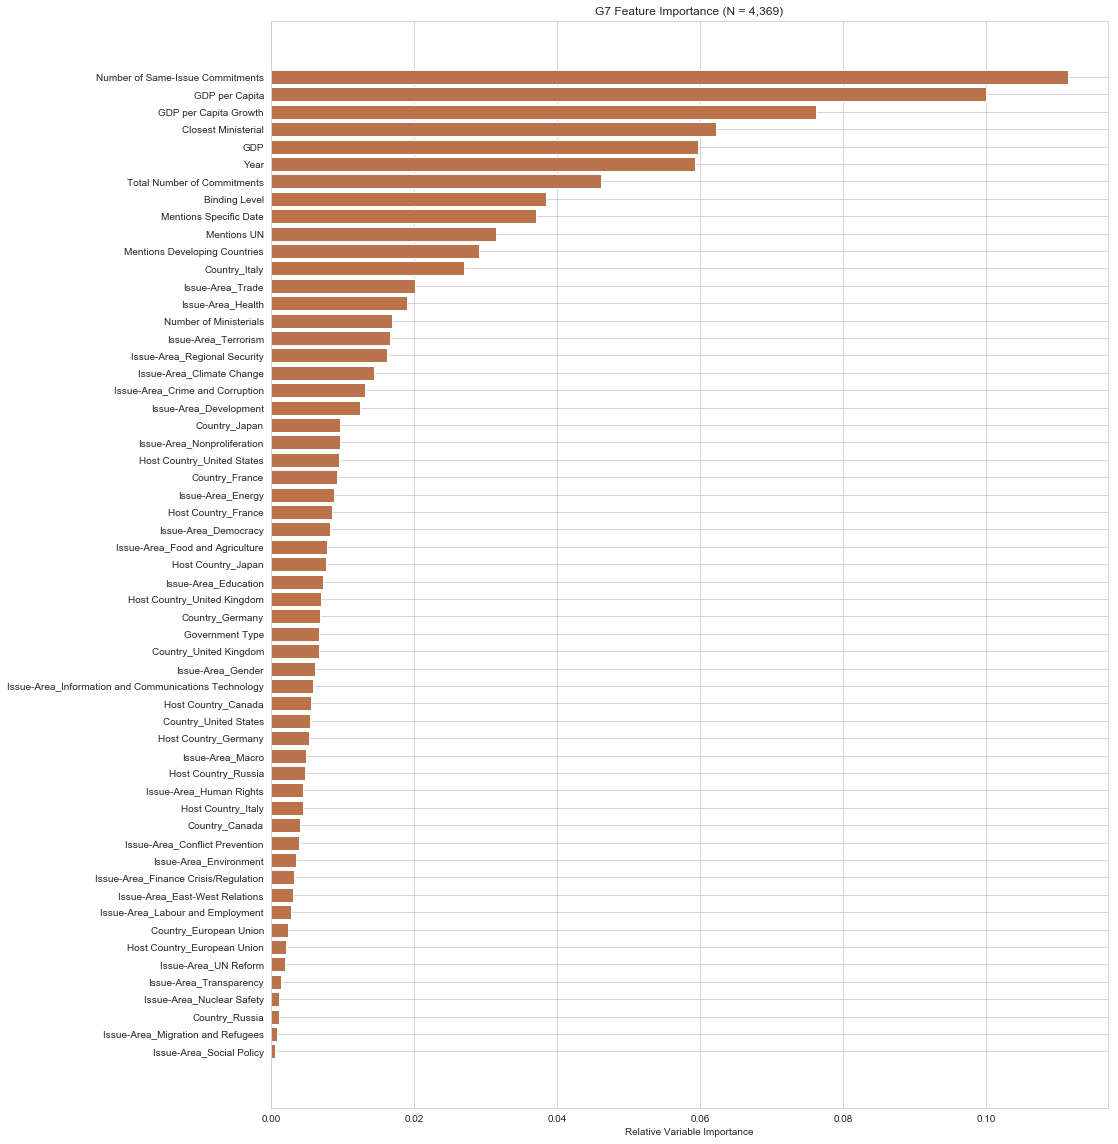

In [4]:
# Drop unused columns and generate model data
unused = ['Commitment Text', 'Average', 'Summit']
df_model = df.drop(unused, axis=1)

# Transform continuous variables
df_model['Compliance Score'] = df_model['Compliance Score'].replace({'+': 1, '-1': -1, '−1': -1})
cont = ['Compliance Score', 'Year', 'Total Number of Commitments',
        'Number of Same-Issue Commitments', 'GDP', 'Number of Ministerials',
        'Closest Ministerial', 'GDP per Capita', 'GDP per Capita Growth']
for i in cont:
    df_model[i] = df_model[i].astype(float)
    
# Export cleaned data
df_model.to_csv('Cleaned G7 Data.csv', index=False)
    
# Transform binary categorical variables
bcat = ['Mentions Specific Date', 'Mentions UN', 'Mentions Developing Countries',
        'Binding Level', 'Government Type']
for i in bcat:
    df_model[i] = pd.get_dummies(df_model[i], drop_first=True)
    
# Transform multiple categorical variables
mcat = ['Issue-Area', 'Country', 'Host Country']
for i in mcat:
    df_model = df_model.join(pd.get_dummies(df[i], prefix=i)).drop(i, axis=1)

# Build random forest regressor model
X = df_model.drop(['Compliance Score'], axis=1)
y = df_model['Compliance Score']
rf_oob = RandomForestRegressor(n_estimators=500, oob_score=True)

# Fit random forest regressor model and get out-of-bag score
rf_oob.fit(X,y)
print('OOB Score: ', rf_oob.oob_score_)

# Test cross-validation of random forest regressor model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)
rf_cv = RandomForestRegressor(n_estimators=500, oob_score=True)

# Print mean absolute error on cross-validation hold out set
rf_cv.fit(X_train,y_train)
y_pred = rf_cv.predict(X_test)
print('MAE: ', mean_absolute_error(y_test, y_pred))

# Get variable importance
features = X.columns.values
importances = rf_oob.feature_importances_
indices = np.argsort(importances)

# Set up plot for variable importance
red = '#BB734C'
plt.figure(figsize=(15, 20))

# Plot variable importance
plt.barh(range(len(indices)), importances[indices], align='center', color=red)
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Variable Importance')
plt.title('G7 Feature Importance (N = 4,369)')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 5})

# Save image
#plt.savefig('Total G7 Feature Importance.svg', bbox_inches='tight')

# Export data
#df_model.to_csv('G7 Model Data.csv', index=False)

In [31]:
# Export variable importance
data = importances[indices]
labels = features[indices]
data = np.array([labels, data])
data = pd.DataFrame(a, ['Relative Variable Importance', 'Variable']).transpose()
data.to_csv('Relative Variable Importance.csv', index=False)

In [5]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4369 entries, 0 to 4368
Data columns (total 58 columns):
Compliance Score                                        4369 non-null float64
Year                                                    4369 non-null float64
Mentions Specific Date                                  4369 non-null uint8
Total Number of Commitments                             4369 non-null float64
Number of Same-Issue Commitments                        4369 non-null float64
Mentions UN                                             4369 non-null uint8
Mentions Developing Countries                           4369 non-null uint8
Binding Level                                           4369 non-null uint8
GDP                                                     4369 non-null float64
GDP per Capita                                          4369 non-null float64
GDP per Capita Growth                                   4369 non-null float64
Number of Ministerials                     

In [6]:
df_model.head()

,Compliance Score,Year,Mentions Specific Date,Total Number of Commitments,Number of Same-Issue Commitments,Mentions UN,Mentions Developing Countries,Binding Level,GDP,GDP per Capita,GDP per Capita Growth,Number of Ministerials,Closest Ministerial,Government Type,Issue-Area_Climate Change,Issue-Area_Conflict Prevention,Issue-Area_Crime and Corruption,Issue-Area_Democracy,Issue-Area_Development,Issue-Area_East-West Relations,Issue-Area_Education,Issue-Area_Energy,Issue-Area_Environment,Issue-Area_Finance Crisis/Regulation,Issue-Area_Food and Agriculture,Issue-Area_Gender,Issue-Area_Health,Issue-Area_Human Rights,Issue-Area_Information and Communications Technology,Issue-Area_Labour and Employment,Issue-Area_Macro,Issue-Area_Migration and Refugees,Issue-Area_Nonproliferation,Issue-Area_Nuclear Safety,Issue-Area_Regional Security,Issue-Area_Social Policy,Issue-Area_Terrorism,Issue-Area_Trade,Issue-Area_Transparency,Issue-Area_UN Reform,Country_Canada,Country_European Union,Country_France,Country_Germany,Country_Italy,Country_Japan,Country_Russia,Country_United Kingdom,Country_United States,Host Country_Canada,Host Country_European Union,Host Country_France,Host Country_Germany,Host Country_Italy,Host Country_Japan,Host Country_Russia,Host Country_United Kingdom,Host Country_United States
0,0.0,1985.0,0,25.0,1.0,0,0,0,3.650000e+11,14114.80776,3.784696,0.0,365.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1.0,1987.0,0,52.0,0.0,0,0,1,4.310000e+11,16308.96697,2.710105,0.0,365.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1.0,1989.0,0,61.0,4.0,0,0,0,5.650000e+11,20715.63148,0.497585,0.0,365.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,-1.0,1989.0,0,61.0,4.0,0,0,1,5.650000e+11,20715.63148,0.497585,0.0,365.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,-1.0,1989.0,0,61.0,4.0,0,0,1,5.650000e+11,20715.63148,0.497585,0.0,365.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
